In [2]:
from functools import partial
import pandas, csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc, hamming_loss, zero_one_loss, \
    jaccard_similarity_score, precision_score, recall_score, roc_auc_score, make_scorer, f1_score
from sklearn.cross_validation import StratifiedKFold as SKF, cross_val_score, KFold
from sklearn import cross_validation
from scipy.special import expit
from sklearn.multiclass import OneVsRestClassifier
from MLC_LabelsetStratify import LabelsetKFold
from pandas import DataFrame as DF
import EPCC
import MLCCommon

In [9]:
dataPath = "../data/"

# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))
badValue = 999
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

# Normalization
df = pandas.DataFrame(X)
df_norm = (df - df.mean()) / (df.max() - df.min())
X = np.copy(df_norm.as_matrix())
print receptor_names
# Real
l = 3
rs = [0,1,9]
print receptor_names[rs]
Yc = Y[:, rs]
ind = np.all(Yc != badValue, axis = 1)
Xm = np.copy(X[ind])
Ym = np.copy(Yc[ind])

Protein names equality check: True
['NR-AhR' 'NR-AR-LBD' 'NR-AR' 'SR-MMP' 'NR-ER' 'SR-HSE' 'SR-p53'
 'NR-PPAR-gamma' 'SR-ARE' 'NR-Aromatase' 'SR-ATAD5' 'NR-ER-LBD']
['NR-AhR' 'NR-AR-LBD' 'NR-Aromatase']


In [10]:
estimator = LR(class_weight = 'balanced', fit_intercept = True, solver='liblinear', n_jobs=3, penalty='l2')
#estimator = RF(n_estimators = 100, n_jobs = 3)

In [14]:
cv = cross_validation.ShuffleSplit(Xm.shape[0], n_iter=1, test_size=.4, random_state=0)
#cv = LabelsetKFold(Yc, n_folds = 5, random_state = 1)
#cv = KFold(Xc.shape[0], n_folds = , random_state = 179)

In [15]:
reload(EPCC)
reload(MLCCommon)
BR = OneVsRestClassifier(estimator = estimator, n_jobs = 3)
EPCC_ = EPCC.EPCC(estimator = estimator, n_estimators = 6, loss = "Rank")
for ITrain, ITest in cv:
    XTrain, YTrain = Xm[ITrain], Ym[ITrain]
    XTest, YTest = Xm[ITest], Ym[ITest]
    BR.fit(XTrain, YTrain)
    EPCC_.fit(XTrain, YTrain)
    YPred1 = EPCC_.predict(XTest)
    YPred2 = BR.predict_proba(XTest)

[1 0 2]
[1 0 2]
[1 2 0]
[1 2 0]
[1 0 2]
[0 1 2]


0.88246535318
0.880056856319


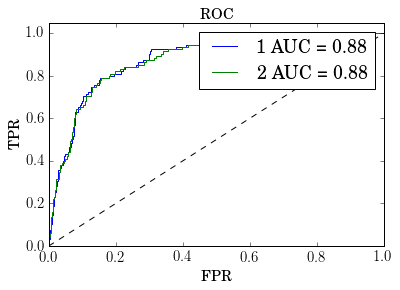

0.856497875354
0.85857825779


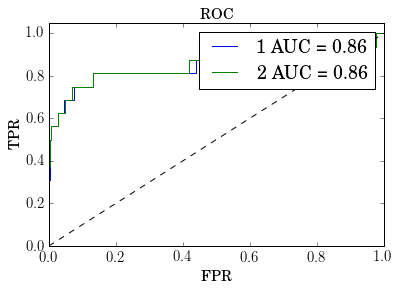

0.821699393359
0.81724936143


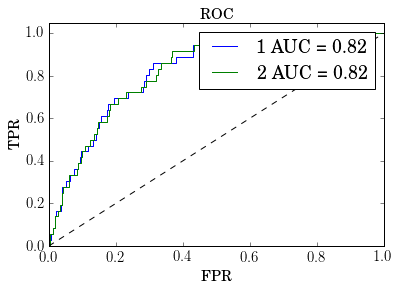

In [16]:
for i in range(l):
        MLCCommon.plotROC(YTest[:, i], [YPred1[:, i], YPred2[:, i]])